In [7]:
import json
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

# auto reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
paper_figure_folder_path = r"output/paper_figures"

# 1. Collect Segment-Level Attention Weights for Analysis per (layer, head, case)

In [9]:
# input/output files directories

# Selected reasoning trace data (randomly select 100 data samples from MATH500 and WildBench)
d_selected_reasoning_trace = {
    'MATH500_sampling': "output/attention_analysis/selected_traces/df_attention_analysis_MATH500.pkl",
    'MATH500_greedy': "output/attention_analysis/selected_traces/df_attention_analysis_MATH500_greedy.pkl",
    'WildBench_sampling': "output/attention_analysis/selected_traces/df_attention_analysis_WildBench.pkl",
}

output_dir = "output/attention_analysis/segment_attn_per_layer_head_case"

In [10]:
dataset_name, is_greedy = "MATH500", False
# dataset_name, is_greedy = "WildBench", False

In [11]:
df_sel = pd.DataFrame()
if dataset_name == "MATH500" and is_greedy:
    df_sel = pd.read_pickle(d_selected_reasoning_trace['MATH500_greedy'])
elif dataset_name == "MATH500" and not is_greedy:
    df_sel = pd.read_pickle(d_selected_reasoning_trace['MATH500_sampling'])
elif dataset_name == "WildBench" and not is_greedy:
    df_sel = pd.read_pickle(d_selected_reasoning_trace['WildBench_sampling'])
else:
    raise ValueError("Invalid dataset or is_greedy value")

display(df_sel.groupby('model').size())
df_sel.head(2)

model
llama-8B-withR        100
llama-8B-withoutR     100
qwen-1p5B-withR       100
qwen-1p5B-withoutR    100
qwen-7B-withR         100
qwen-7B-withoutR      100
r1-full-withR         100
r1-full-withoutR      100
dtype: int64

,unique_id,problem,response,model,latency,is_response_finished,answer_pred,extracted_answer,is_answer_extracted,end_think_count,answer,subject,level,is_answer_correct
16,test/intermediate_algebra/134.json,Compute: $1-2+3-4+5- \dots +99-100$.,<｜begin▁of▁sentence｜>Compute: $1-2+3-4+5- \dot...,llama-8B-withoutR,NaN,1,\n\nTo compute the series \(1 - 2 + 3 - 4 + 5 ...,-50,1,2,-50,Intermediate Algebra,1,1
24,test/algebra/2427.json,"A worker receives an annual wage of $\$20{,}00...",<｜begin▁of▁sentence｜>A worker receives an annu...,llama-8B-withoutR,NaN,1,\n\nTo determine the minimal compound interest...,48.7\%,1,2,10,Algebra,5,0


In [ ]:
import torch
from transformer_lens import HookedTransformer
from attention_analysis import get_attention_pattern_by_layer_head
from const import D_MODEL_ALIAS_PATH

def _get_output_fp(output_dir, model_alias, dataset_name, with_R_option, is_greedy):
    fp_name = f"layer_head_{model_alias}_{dataset_name}"
    if with_R_option == 'withR':
        fp_name += "_withR"
    else:
        fp_name += "_withoutR"
    if is_greedy:
        fp_name += "_greedy"
    fp_name += ".pkl"
    return os.path.join(output_dir, fp_name)
        
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_grad_enabled(False)

for model_alias, model_path in D_MODEL_ALIAS_PATH.items():
    print(f"Processing model: {model_alias}")

    model = HookedTransformer.from_pretrained_no_processing(
        model_path,
        dtype=torch.bfloat16,
        device=device
    )

    for with_R_option in ['withR', 'withoutR']:
        df_tmp = df_sel[df_sel['model'].str.contains(model_alias)]
        if with_R_option == 'withR':
            df_tmp = df_tmp[df_tmp['model'].str.contains('withR')]
        else:
            df_tmp = df_tmp[df_tmp['model'].str.contains('withoutR')]
        assert len(df_tmp) == 100, f"Expected 100 rows, got {len(df_tmp)}"
        
        d_res = {}
        for i, row in tqdm(df_tmp.iterrows()):
            a2r_mean, a2p_mean, a2a_mean, r2r_mean, r2p_mean, token_len, r_start_idx, r_end_idx, answer_token_region, a2bos_mean, a2bot_mean, a2eot_mean, r2bos_mean, r2bot_mean = get_attention_pattern_by_layer_head(
                    text=row['response'],
                    model=model,
                    answer_ratio_region=(0., 1),
                    pattern_hook_names_filter=lambda name: name.endswith("pattern")
                )
            
            d_tmp = {}
            d_tmp['unique_id'] = row['unique_id']
            d_tmp['a2r'] = a2r_mean
            d_tmp['a2p'] = a2p_mean
            d_tmp['a2a'] = a2a_mean
            d_tmp['r2r'] = r2r_mean
            d_tmp['r2p'] = r2p_mean
            d_tmp['token_len'] = token_len
            d_tmp['r_start_idx'] = r_start_idx
            d_tmp['r_end_idx'] = r_end_idx
            d_tmp['answer_token_region'] = answer_token_region
            d_tmp['a2bos'] = a2bos_mean
            d_tmp['a2bot'] = a2bot_mean
            d_tmp['a2eot'] = a2eot_mean
            d_tmp['r2bos'] = r2bos_mean
            d_tmp['r2bot'] = r2bot_mean

            d_res[row['unique_id']] = d_tmp
            save_path = _get_output_fp(output_dir, model_alias, dataset_name, with_R_option, is_greedy)
            with open(save_path, 'wb') as f:
                pickle.dump(d_res, f)

# 2. Analysis & Plotting

In [12]:
per_layer_head_case_res_dir = r"output/attention_analysis/segment_attn_per_layer_head_case"

In [13]:
dataset_name, is_withR = 'MATH500', True
# dataset_name, is_withR = 'WildBench', True

In [14]:
from const import D_MODEL_ALIAS_LABEL_MAPPING

d_res = {}
l_model_alias = list(D_MODEL_ALIAS_LABEL_MAPPING.keys())
for model_alias in l_model_alias:
    if is_withR:
        save_path = os.path.join(per_layer_head_case_res_dir, f"layer_head_{model_alias}_{dataset_name}_withR.pkl")
    else:
        save_path = os.path.join(per_layer_head_case_res_dir, f"layer_head_{model_alias}_{dataset_name}_withoutR.pkl")

    with open(save_path, 'rb') as f:
        d_res[model_alias] = pickle.load(f)

## 2.1 Segment-Level & Aggregated Attention Weights

In [15]:
# Initialize dictionaries to store data for each model
a2r_all_by_model = {model_alias: [] for model_alias in l_model_alias}
a2p_all_by_model = {model_alias: [] for model_alias in l_model_alias}
a2a_all_by_model = {model_alias: [] for model_alias in l_model_alias}
r2r_all_by_model = {model_alias: [] for model_alias in l_model_alias}
r2p_all_by_model = {model_alias: [] for model_alias in l_model_alias}

a2bos_all_by_model = {model_alias: [] for model_alias in l_model_alias}
a2bot_all_by_model = {model_alias: [] for model_alias in l_model_alias}
a2eot_all_by_model = {model_alias: [] for model_alias in l_model_alias}

r2bos_all_by_model = {model_alias: [] for model_alias in l_model_alias}
r2bot_all_by_model = {model_alias: [] for model_alias in l_model_alias}

token_len_all_by_model = {model_alias: [] for model_alias in l_model_alias}
reasoning_token_len_all_by_model = {model_alias: [] for model_alias in l_model_alias}

for model_alias in l_model_alias:
    for uid in d_res[model_alias].keys():
            
        a2r_mean = d_res[model_alias][uid]['a2r']
        a2p_mean = d_res[model_alias][uid]['a2p']
        a2a_mean = d_res[model_alias][uid]['a2a']
        r2r_mean = d_res[model_alias][uid]['r2r']
        r2p_mean = d_res[model_alias][uid]['r2p']
        token_len = d_res[model_alias][uid]['token_len']
        r_start_idx = d_res[model_alias][uid]['r_start_idx']
        r_end_idx = d_res[model_alias][uid]['r_end_idx']

        a2bos_mean = d_res[model_alias][uid]['a2bos']
        a2bot_mean = d_res[model_alias][uid]['a2bot']
        a2eot_mean = d_res[model_alias][uid]['a2eot']

        r2bos_mean = d_res[model_alias][uid]['r2bos']
        r2bot_mean = d_res[model_alias][uid]['r2bot']

        # Add to model-specific collections
        a2r_all_by_model[model_alias].append(a2r_mean)
        a2p_all_by_model[model_alias].append(a2p_mean)
        a2a_all_by_model[model_alias].append(a2a_mean)
        r2r_all_by_model[model_alias].append(r2r_mean)
        r2p_all_by_model[model_alias].append(r2p_mean)
        token_len_all_by_model[model_alias].append(token_len)
        reasoning_token_len_all_by_model[model_alias].append(r_end_idx - r_start_idx)

        a2bos_all_by_model[model_alias].append(a2bos_mean)
        a2bot_all_by_model[model_alias].append(a2bot_mean)
        a2eot_all_by_model[model_alias].append(a2eot_mean)
        
        r2bos_all_by_model[model_alias].append(r2bos_mean)
        r2bot_all_by_model[model_alias].append(r2bot_mean)

# Calculate per-case averages for each model
a2r_per_case_by_model = {model_alias: np.array(a2r_all_by_model[model_alias]).mean(axis=-1).mean(axis=-1) 
                         for model_alias in l_model_alias}
a2p_per_case_by_model = {model_alias: np.array(a2p_all_by_model[model_alias]).mean(axis=-1).mean(axis=-1)
                         for model_alias in l_model_alias}
a2a_per_case_by_model = {model_alias: np.array(a2a_all_by_model[model_alias]).mean(axis=-1).mean(axis=-1)
                         for model_alias in l_model_alias}
r2r_per_case_by_model = {model_alias: np.array(r2r_all_by_model[model_alias]).mean(axis=-1).mean(axis=-1)
                         for model_alias in l_model_alias}
r2p_per_case_by_model = {model_alias: np.array(r2p_all_by_model[model_alias]).mean(axis=-1).mean(axis=-1)
                         for model_alias in l_model_alias}

a2bos_per_case_by_model = {model_alias: np.array(a2bos_all_by_model[model_alias]).mean(axis=-1).mean(axis=-1)
                         for model_alias in l_model_alias}
a2bot_per_case_by_model = {model_alias: np.array(a2bot_all_by_model[model_alias]).mean(axis=-1).mean(axis=-1)
                         for model_alias in l_model_alias}
a2eot_per_case_by_model = {model_alias: np.array(a2eot_all_by_model[model_alias]).mean(axis=-1).mean(axis=-1)
                            for model_alias in l_model_alias}
r2bos_per_case_by_model = {model_alias: np.array(r2bos_all_by_model[model_alias]).mean(axis=-1).mean(axis=-1)
                            for model_alias in l_model_alias}
r2bot_per_case_by_model = {model_alias: np.array(r2bot_all_by_model[model_alias]).mean(axis=-1).mean(axis=-1)
                            for model_alias in l_model_alias}

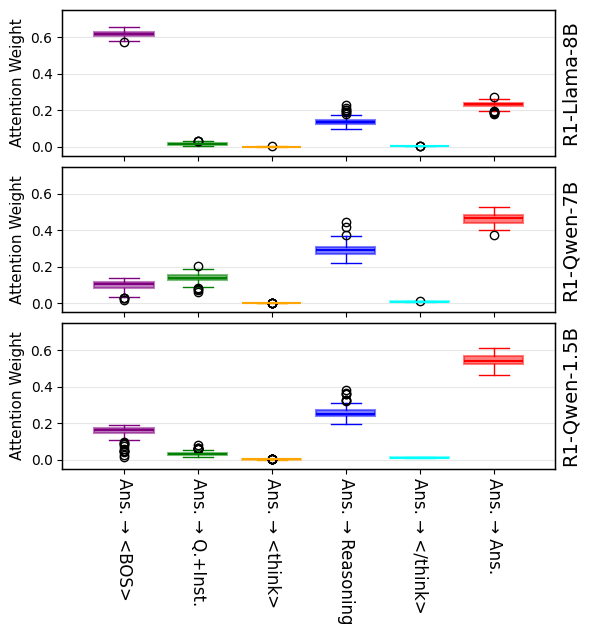

In [16]:
# Create a figure for the box plots comparing all models in a 3x1 grid
fig, axes = plt.subplots(3, 1, figsize=(6, 7), sharex=True)

d_model_alias_label_mapping = {
    'llama-8B': 'R1-Llama-8B',
    'qwen-7B': 'R1-Qwen-7B',
    'qwen-1p5B': 'R1-Qwen-1.5B'
}

# Data for plotting by model and attention type - reordered as requested
attention_types = ['Ans. → <BOS>', 'Ans. → Q.+Inst.', 'Ans. → <think>', 'Ans. → Reasoning', 'Ans. → </think>', 'Ans. → Ans.']
attention_data = {
    'a2bos': a2bos_per_case_by_model,
    'a2p': a2p_per_case_by_model,
    'a2bot': a2bot_per_case_by_model,
    'a2r': a2r_per_case_by_model,
    'a2eot': a2eot_per_case_by_model,
    'a2a': a2a_per_case_by_model
}

# Use a different color for each attention type
attention_colors = {
    'a2bos': 'purple',
    'a2p': 'green',
    'a2bot': 'orange',
    'a2r': 'blue',
    'a2eot': 'cyan',
    'a2a': 'red'
}

# Position settings - ensure uniform distribution
width = 0.12  # width of bars
offsets = np.linspace(-0.3, 0.3, 6)  # Create 6 uniformly distributed positions

# Create grouped box plots for each model in a separate subplot
for i, model_alias in enumerate(l_model_alias):
    ax = axes[i]
    
    for j, (attn_key, attn_name, offset) in enumerate(zip(
            ['a2bos', 'a2p', 'a2bot', 'a2r', 'a2eot', 'a2a'], 
            attention_types, 
            offsets)):
        data = attention_data[attn_key][model_alias]
        
        # Draw boxplot for each attention type and model with colors
        bp = ax.boxplot([data], 
              positions=[offset], 
              patch_artist=True,
              widths=width*0.8,
              showmeans=False,
              showfliers=True)
        
        # Set box properties with colors
        for box in bp['boxes']:
            box.set_facecolor(attention_colors[attn_key])
            box.set_alpha(0.5)
            box.set_edgecolor(attention_colors[attn_key])
            box.set_linewidth(1.5)
        
        # Set the median line to black
        for median in bp['medians']:
            median.set_color(attention_colors[attn_key])
            median.set_linewidth(1.5)
        
        # Set whisker and cap colors
        for whisker in bp['whiskers']:
            whisker.set_color(attention_colors[attn_key])
            whisker.set_linewidth(1.0)
            
        for cap in bp['caps']:
            cap.set_color(attention_colors[attn_key])
            cap.set_linewidth(1.0)
    
    # Set y label for each subplot
    ax.set_ylabel('Attention Weight', fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    # Create a second y-axis for the model name
    ax2 = ax.twinx()
    ax2.set_ylabel(d_model_alias_label_mapping[model_alias], fontsize=14)
    ax2.set_yticks([])  # Hide the ticks of the secondary y-axis
    
    # Adjust x-axis limits to have consistent margins
    ax.set_xlim(-0.4, 0.4)
    ax.set_ylim(-0.05, 0.75)

    # Set x-ticks and labels for each subplot
    ax.set_xticks([])  # No labels for intermediate subplots
        
    # Only show x-tick labels on the bottom subplot if this is the last model
    if i == len(l_model_alias) - 1:
        ax.set_xticks(offsets)
        ax.set_xticklabels(attention_types, rotation=-90, ha='center', fontsize=12)
    
    # Set spines
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.0)

# Create legend for attention types
legend_elements = [plt.Line2D([0], [0], marker='s', color=color, 
                            markerfacecolor=color, markersize=10, 
                            label=name) for name, color in zip(
                                attention_types, 
                                [attention_colors[k] for k in ['a2bos', 'a2p', 'a2bot', 'a2r', 'a2eot', 'a2a']])]


plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.075)

# save_fg_path = os.path.join(paper_figure_folder_path, f'answer_attn_decompose_{dataset_name}_withR.png')
# if not os.path.exists(os.path.dirname(save_fg_path)):
#     os.makedirs(os.path.dirname(save_fg_path))
# plt.savefig(save_fg_path, dpi=300, bbox_inches='tight')
# # save as pdf
# save_fg_path_pdf = os.path.join(paper_figure_folder_path, f'answer_attn_decompose_{dataset_name}_withR.pdf')
# plt.savefig(save_fg_path_pdf, dpi=300, bbox_inches='tight')

plt.show()


## 2.2 Across Model Layers and Heads

In [17]:
# Initialize dictionaries to store data for each model
a2r_all_by_model = {model_alias: [] for model_alias in l_model_alias}
a2p_all_by_model = {model_alias: [] for model_alias in l_model_alias}
a2a_all_by_model = {model_alias: [] for model_alias in l_model_alias}
r2r_all_by_model = {model_alias: [] for model_alias in l_model_alias}
r2p_all_by_model = {model_alias: [] for model_alias in l_model_alias}

a2bos_all_by_model = {model_alias: [] for model_alias in l_model_alias}
a2bot_all_by_model = {model_alias: [] for model_alias in l_model_alias}
a2eot_all_by_model = {model_alias: [] for model_alias in l_model_alias}

r2bos_all_by_model = {model_alias: [] for model_alias in l_model_alias}
r2bot_all_by_model = {model_alias: [] for model_alias in l_model_alias}

token_len_all_by_model = {model_alias: [] for model_alias in l_model_alias}
reasoning_token_len_all_by_model = {model_alias: [] for model_alias in l_model_alias}

for model_alias in l_model_alias:
    
    for uid in tqdm(d_res[model_alias].keys()):            
        a2r_mean = d_res[model_alias][uid]['a2r']
        a2p_mean = d_res[model_alias][uid]['a2p']
        a2a_mean = d_res[model_alias][uid]['a2a']
        r2r_mean = d_res[model_alias][uid]['r2r']
        r2p_mean = d_res[model_alias][uid]['r2p']
        token_len = d_res[model_alias][uid]['token_len']
        r_start_idx = d_res[model_alias][uid]['r_start_idx']
        r_end_idx = d_res[model_alias][uid]['r_end_idx']

        a2bos_mean = d_res[model_alias][uid]['a2bos']
        a2bot_mean = d_res[model_alias][uid]['a2bot']
        a2eot_mean = d_res[model_alias][uid]['a2eot']

        r2bos_mean = d_res[model_alias][uid]['r2bos']
        r2bot_mean = d_res[model_alias][uid]['r2bot']

        # Add to model-specific collections
        a2r_all_by_model[model_alias].append(a2r_mean)
        a2p_all_by_model[model_alias].append(a2p_mean)
        a2a_all_by_model[model_alias].append(a2a_mean)
        r2r_all_by_model[model_alias].append(r2r_mean)
        r2p_all_by_model[model_alias].append(r2p_mean)
        token_len_all_by_model[model_alias].append(token_len)
        reasoning_token_len_all_by_model[model_alias].append(r_end_idx - r_start_idx)

        a2bos_all_by_model[model_alias].append(a2bos_mean)
        a2bot_all_by_model[model_alias].append(a2bot_mean)
        a2eot_all_by_model[model_alias].append(a2eot_mean)
        
        r2bos_all_by_model[model_alias].append(r2bos_mean)
        r2bot_all_by_model[model_alias].append(r2bot_mean)

100%|██████████| 100/100 [00:00<00:00, 425385.80it/s]


In [19]:
from utils.utils_MI import get_topk_head_pos
from const import D_TOP_RETRIEVAL_HEADS, D_TOP_INDUCTION_HEADS, D_MODEL_ALIAS_LABEL_MAPPING

/tmp/ipykernel_3072599/2996957514.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to accommodate colorbar


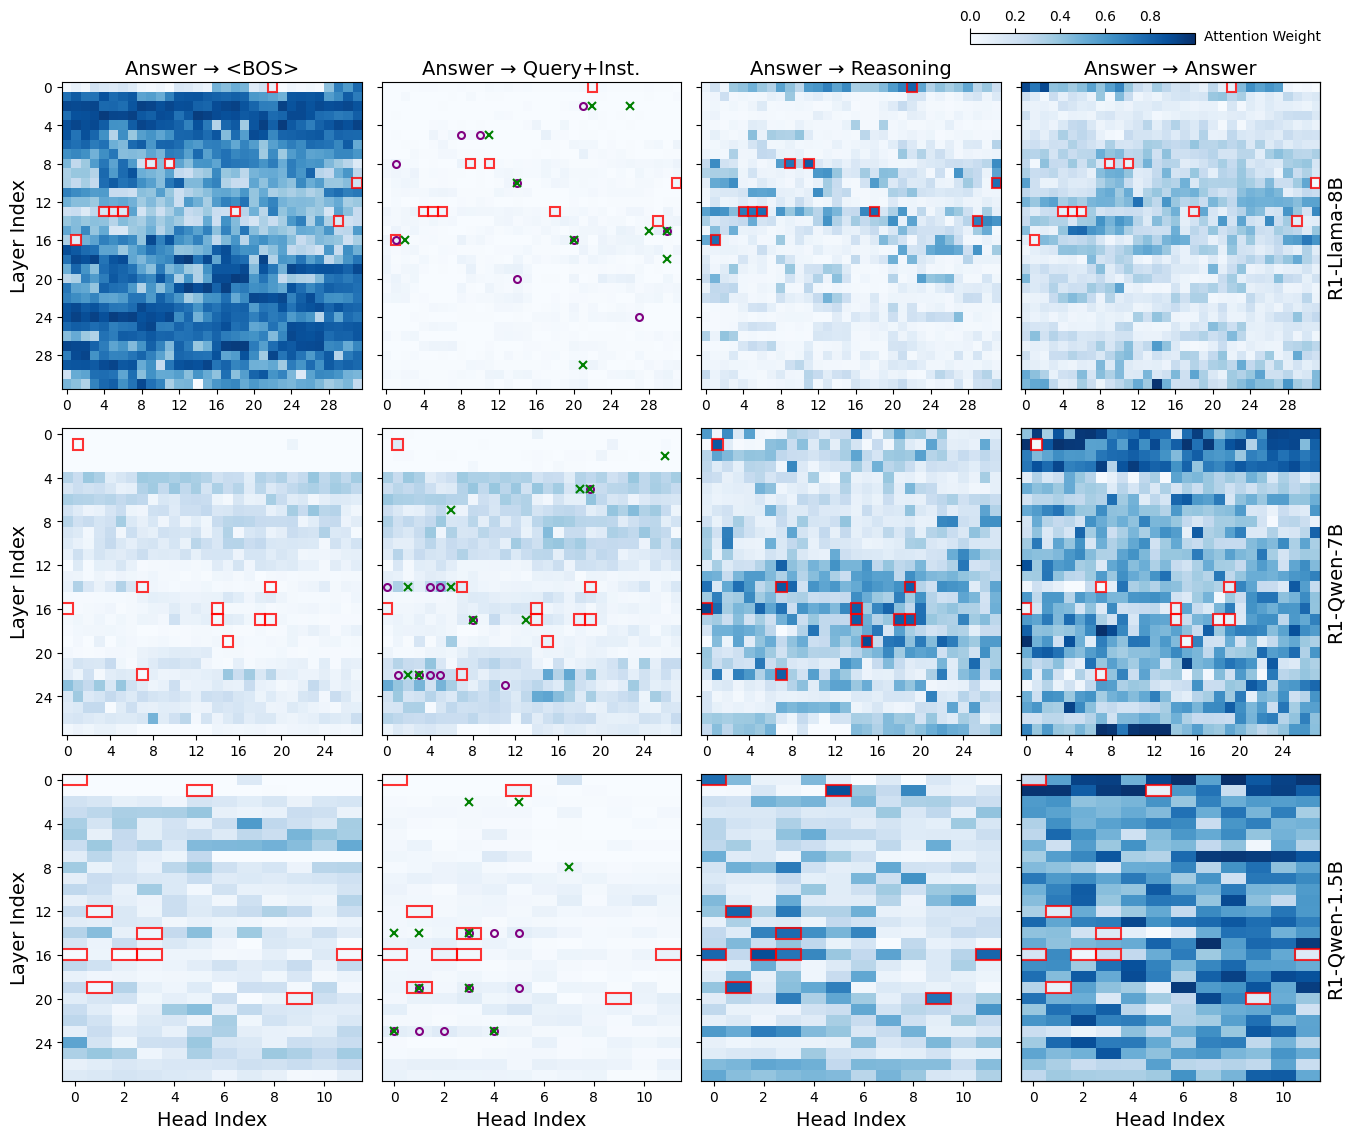

In [20]:
# Define models and attention types
model_aliases = ['llama-8B', 'qwen-7B', 'qwen-1p5B']
attention_types = ['a2bos', 'a2p', 'a2r', 'a2a']
attention_labels = ['Answer → <BOS>', 'Answer → Query+Inst.', 'Answer → Reasoning', 'Answer → Answer']

# Find global min and max for consistent colorbar across all plots
vmin = float('inf')
vmax = float('-inf')

for model_alias in model_aliases:
    attention_arrays = [
        np.array(a2bos_all_by_model[model_alias]).mean(axis=0),
        np.array(a2p_all_by_model[model_alias]).mean(axis=0),
        np.array(a2r_all_by_model[model_alias]).mean(axis=0),
        np.array(a2a_all_by_model[model_alias]).mean(axis=0)
    ]
    model_min = min([arr.min() for arr in attention_arrays])
    model_max = max([arr.max() for arr in attention_arrays])
    vmin = min(vmin, model_min)
    vmax = max(vmax, model_max)

# Create a grid of subplots with shared y-axes per row
fig, axes = plt.subplots(3, 4, figsize=(15, 11), sharey='row')

# Create heatmaps for each model and attention type
images = []
for model_idx, model_alias in enumerate(model_aliases):
    # Get dimensions of attention matrices for this model
    num_layers, num_heads = np.array(a2bos_all_by_model[model_alias]).mean(axis=0).shape
    
    # Prepare attention arrays for this model
    attention_arrays = [
        np.array(a2bos_all_by_model[model_alias]).mean(axis=0),
        np.array(a2p_all_by_model[model_alias]).mean(axis=0),
        np.array(a2r_all_by_model[model_alias]).mean(axis=0),
        np.array(a2a_all_by_model[model_alias]).mean(axis=0)
    ]
    
    # Get top k retrieval heads for reasoning attention
    topk_a2r = 10
    topk_coords_a2r, _ = get_topk_head_pos(attention_arrays[2], topk=topk_a2r)
    
    for attn_idx, (attn_type, attn_label, attn_data) in enumerate(zip(attention_types, attention_labels, attention_arrays)):
        ax = axes[model_idx, attn_idx]
        im = ax.imshow(attn_data, cmap='Blues', aspect='auto', vmin=vmin, vmax=vmax)
        images.append(im)
        
        # Configure axis and labels
        if model_idx == 0:  # Only add title for the first row
            ax.set_title(attn_label, fontsize=14)
        
        if attn_idx == 0:  # Only add y-label for the first column
            ax.set_ylabel(f'Layer Index', fontsize=14)
            
        if model_idx == 2:  # Only add x-label for the bottom row
            ax.set_xlabel('Head Index', fontsize=14)
        
        # Add grid lines but with reduced number of ticks for clarity
        ax.set_xticks(np.arange(0, num_heads, 2))
        ax.set_yticks(np.arange(0, num_layers, 4))

        # Label axes with indices
        ax.set_xticklabels(np.arange(0, num_heads, 2))
        ax.set_yticklabels(np.arange(0, num_layers, 4))
        if model_alias in ['llama-8B', 'qwen-7B']:
            ax.set_xticks(np.arange(0, num_heads, 4))
            ax.set_xticklabels(np.arange(0, num_heads, 4))

        # Create a second y-axis for the model name
        if attn_idx == 3:
            ax2 = ax.twinx()
            ax2.set_ylabel(D_MODEL_ALIAS_LABEL_MAPPING[model_alias], fontsize=14)
            ax2.set_yticks([])  # Hide the ticks of the secondary y-axis
        
        
        # Add grid for better visualization
        ax.grid(False)
        
        # Draw indicators for top retrieval heads if available for this model
        if model_alias in D_TOP_RETRIEVAL_HEADS:
            for head_info in D_TOP_RETRIEVAL_HEADS[model_alias]:
                layer_idx, head_idx = head_info[0]
                
                if attn_idx == 1:  # Only for Answer → Reasoning plot
                    # ax.text(head_idx, layer_idx, "R", 
                    #     ha='center', va='center', color='purple', fontweight='bold',
                    #     fontsize=8)
                    ax.plot(head_idx, layer_idx, 'o', color='purple', markersize=5, markeredgewidth=1.5, fillstyle='none',)  # Circle for R
            
            if attn_idx == 1:  # Only for Answer → Reasoning plot
                for head_info in D_TOP_INDUCTION_HEADS[model_alias]:
                    layer_idx, head_idx = head_info                    
                    # ax.text(head_idx, layer_idx, "I", 
                    #     ha='center', va='center', color='green', fontweight='bold',
                    #     fontsize=8)
                    ax.plot(head_idx, layer_idx, 'x', color='green', markersize=6, markeredgewidth=1.5)  # Cross for I

        
        # Plot high reasoning heads
        for head_info in topk_coords_a2r:
            layer_idx, head_idx = head_info
            
            # Create a rectangle patch around the specified head
            rect = plt.Rectangle((head_idx - 0.5, layer_idx - 0.5), 1, 1, 
                            fill=False, edgecolor='red', linewidth=1.5, alpha=0.8)
            ax.add_patch(rect)

# Add a compact colorbar
cbar_ax = fig.add_axes([0.65, 1.0, 0.15, 0.01])  # [x, y, width, height]
cbar = fig.colorbar(images[0], cax=cbar_ax, orientation='horizontal')
plt.text(1.3, 0.73, "Attention Weight", ha='center', va='center', fontsize=10)
cbar.ax.xaxis.set_ticks_position('top')
# cbar.set_label('Attention Weight', fontsize=12)
# cbar.ax.xaxis.set_label_position('top')

plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to accommodate colorbar

# save_fg_path = os.path.join(paper_figure_folder_path, f'attn_map_{dataset_name}.png')
# if not os.path.exists(os.path.dirname(save_fg_path)):
#     os.makedirs(os.path.dirname(save_fg_path))
# plt.savefig(save_fg_path, dpi=300, bbox_inches='tight')
# # save as pdf
# save_fg_path_pdf = os.path.join(paper_figure_folder_path, f'attn_map_{dataset_name}.pdf')
# plt.savefig(save_fg_path_pdf, dpi=300, bbox_inches='tight')

plt.show()